# Siamese network in keras to detect pairs of scatter plots that are similar.

In [1]:
import numpy as np
import os

import glob
import random 

from PIL import Image

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Flatten, BatchNormalization
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam

In [2]:
POS_LABEL = 0 # Pair of plots that match
NEG_LABEL = 1 # Pair of plots that do not match
#If you reverse the labels, you have to change the Contrastive Loss function.
SZ = 128
MARGIN = 5.0

## Siamese Model

In [3]:
def feature_extract(inputShape):
    
    inputs = Input(inputShape)
    
    x = Conv2D(4, (3, 3), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    
    x = Conv2D(8, (3, 3), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    
    x = Conv2D(8, (3, 3), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    
    x = Dense(500, activation="relu")(x)
    x = Dense(500, activation="relu")(x)
    outputs = Dense(5)(x)
    
    return Model(inputs, outputs,name='sister_network')
    return model


def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y,preds):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(MARGIN - preds, 0.0))
    loss = K.mean((1-y) * squaredPreds + y * squaredMargin)
    return loss

## Make pairs of images for training and testing

In [4]:
def get_positive_pairs(path='./mol_data/*'): #both images of same digit
    positive_pairs = []
    all_fam_dirs = glob.glob(path)
    for famdir in all_fam_dirs:
        mol_files = glob.glob(famdir+'/*.png')
        for ff1 in mol_files:
            for ff2 in mol_files:
                if ff1 < ff2:
                    positive_pairs.append((ff1,ff2))
    return positive_pairs


def get_negative_pairs(path='./mol_data/*',cnt=100): #images are from different digits
    negative_pairs = []
    all_fam_dirs = glob.glob(path)
    random.shuffle(all_fam_dirs)
    all_fam_dirs_rev = all_fam_dirs[::-1] #reversed
    for famdir1,famdir2 in zip(all_fam_dirs,all_fam_dirs_rev):
        if famdir1!=famdir2:
            mol_files_1 = glob.glob(famdir1+'/*.png')
            mol_files_2 = glob.glob(famdir2+'/*.png')
            for ff1 in mol_files_1:
                for ff2 in mol_files_2:
                    negative_pairs.append((ff1,ff2))
        if len(negative_pairs) >= cnt:
            break
            
    return negative_pairs


def read_img(img_path):
    img = Image.open(img_path)
    img = img.convert('L')
    img = img.resize((SZ,SZ))
    img = np.asarray(img,dtype=np.float32)/255.0
    return img

def build_paired_data(path,shuffle):
    positive_pairs = get_positive_pairs(path) 
    negative_pairs = get_negative_pairs(path,len(positive_pairs))
    
    print('Got ',len(positive_pairs),'positive_pairs')
    print('Got ',len(negative_pairs),'negative_pairs')
    
    if shuffle:
        random.shuffle(positive_pairs)
        random.shuffle(negative_pairs)
        
    positive_labels = [POS_LABEL]*len(positive_pairs)
    negative_labels = [NEG_LABEL]*len(negative_pairs)

    all_pairs = positive_pairs + negative_pairs
    all_labels = positive_labels + negative_labels
 
    data = list(zip(all_pairs,all_labels))
    random.shuffle(data)
    print('Loading data size',len(data))
    
    pairImages = []
    pairLabels = []
    pairNames = []

    for image_pair,label in data:
        img0 = read_img(image_pair[0])
        img1 = read_img(image_pair[1])
        
        pairImages.append([img0,img1])
        pairLabels.append([label]) #very important to have labels as shape `batch_size` x 1   
        pairNames.append([image_pair[0],image_pair[1]])
        
    return np.expand_dims(np.array(pairImages),axis=-1), np.array(pairLabels), np.array(pairNames)


pairData, labelData, pairNames = build_paired_data('./mol_data/*',True)
print(pairData.shape, labelData.shape)

Got  200 positive_pairs
Got  200 negative_pairs
Loading data size 400
(400, 2, 128, 128, 1) (400, 1)


## Compute prediction accuracy

In [5]:
def get_accuracy(model,ImgArr0,ImgArr1,labelArr):
    PP = model.predict_on_batch([ImgArr0, ImgArr1])
    preds = (PP > MARGIN).astype(int)
    acc = np.sum(preds==labelArr)/len(labelArr)
    return acc

## Build and compile the model

In [6]:
# specify the shape of the inputs for our network
IMG_SHAPE = (SZ, SZ, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 16
EPOCHS = 30

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = feature_extract(IMG_SHAPE)
featureExtractor.summary()

featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
    
model = Model(inputs=[imgA, imgB], outputs=distance)

print(model.summary())

optm = Adam(lr=0.0005)

print("Compiling model...")
model.compile(loss=contrastive_loss, optimizer=optm)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               65536500  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
Total para

## Training and testing

In [7]:
#Train-test split : 80:20 ratio
k = int(len(pairData)*0.80)
imgArr0_train = pairData[:k,0]
imgArr1_train = pairData[:k,1]
label_train = labelData[:k]

imgArr0_test = pairData[k:,0]
imgArr1_test = pairData[k:,1]
label_test = labelData[k:]

print('Size of training data',imgArr0_train.shape,imgArr1_train.shape)
print('Size of testing data',imgArr0_test.shape,imgArr1_test.shape)

history = model.fit(
    [imgArr0_train, imgArr1_train], label_train,
    validation_data=([imgArr0_test, imgArr1_test], label_test) ,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS)

Size of training data (320, 128, 128, 1) (320, 128, 128, 1)
Size of testing data (80, 128, 128, 1) (80, 128, 128, 1)
Train on 320 samples, validate on 80 samples
Epoch 1/30
320/320 [==============================] - 6s 18ms/step - loss: 23.1152 - val_loss: 9.7706
Epoch 2/30
320/320 [==============================] - 3s 8ms/step - loss: 6.6463 - val_loss: 8.8290
Epoch 3/30
320/320 [==============================] - 3s 8ms/step - loss: 2.4937 - val_loss: 9.0688
Epoch 4/30
320/320 [==============================] - 3s 8ms/step - loss: 0.6881 - val_loss: 8.6400
Epoch 5/30
320/320 [==============================] - 3s 8ms/step - loss: 0.1923 - val_loss: 8.0368
Epoch 6/30
320/320 [==============================] - 3s 8ms/step - loss: 0.0717 - val_loss: 7.5116
Epoch 7/30
320/320 [==============================] - 3s 8ms/step - loss: 0.0294 - val_loss: 6.8271
Epoch 8/30
320/320 [==============================] - 3s 8ms/step - loss: 0.0118 - val_loss: 6.1009
Epoch 9/30
320/320 [================

## Training statistics

Final Training accuracy= 0.9875
Final Validation accuracy= 1.0

Training and validation losses...


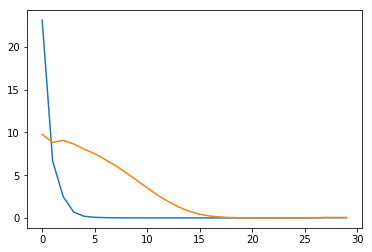

In [8]:
print('Final Training accuracy=',get_accuracy(model,imgArr0_train, imgArr1_train, label_train))
print('Final Validation accuracy=',get_accuracy(model,imgArr0_test, imgArr1_test, label_test))
print('\nTraining and validation losses...')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.show()

## Plot 10 pairs of images and their dissimilarities.

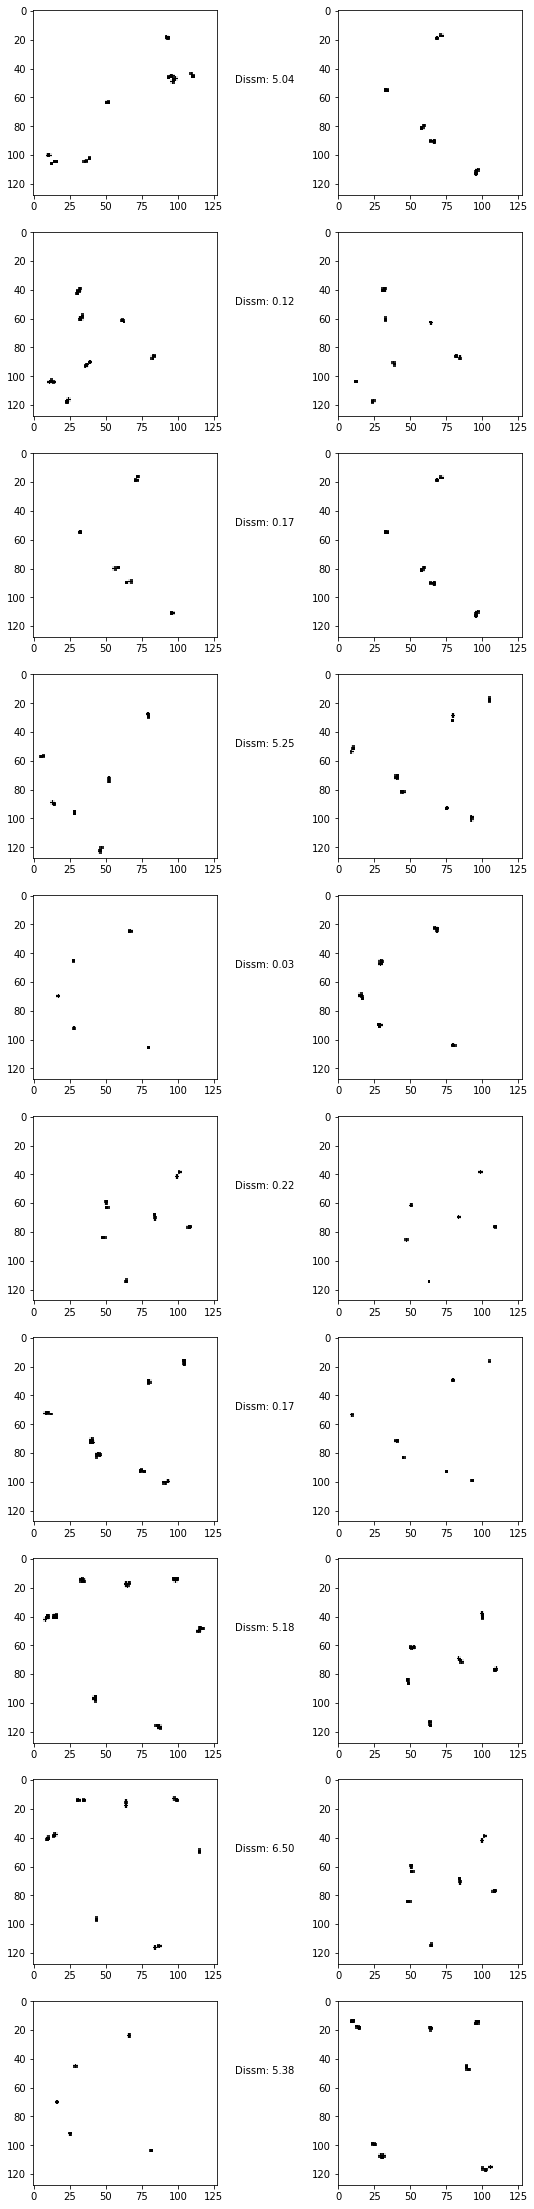

In [9]:
fig, axs = plt.subplots(10, 2, figsize=(10,40)) #, sharex=True, sharey=True)

A = imgArr0_test[:10]
B = imgArr1_test[:10]

distances = model.predict_on_batch([A,B])

i = 0
for img0, img1 in zip(A,B):
    img0 = np.squeeze(img0)
    img1 = np.squeeze(img1)
    axs[i,0].imshow(img0,cmap='gray')
    axs[i,1].imshow(img1,cmap='gray')
    text = 'Dissm: {:.2f}'.format(float(distances[i]))
    axs[i,0].text(140, 50, text) 
    i += 1